# Face Validation Model ##

In [37]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
from PIL import Image
import matplotlib.patches as patches
import keras
import shutil
from shutil import unpack_archive
from subprocess import check_output

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf
from sklearn.utils import shuffle

import tensorflow.keras.backend as K
import tensorflow
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import *

import random 
random.seed(42)

### Loading the dataset. The dataset conatins both paired and unpaired set. Load the pair.csv ###

In [38]:
# Read in Data
pairs = pd.read_csv("../input/lfw-dataset/pairs.csv")
pairs = pairs.rename(columns ={'name': 'name1', 'Unnamed: 3': 'name2'})



### Print the first 10 rows of the dataset ###

In [39]:
print(pairs.head(10))

                   name1  imagenum1 imagenum2  name2
0           Abel_Pacheco          1         4    NaN
1         Akhmed_Zakayev          1         3    NaN
2         Akhmed_Zakayev          2         3    NaN
3          Amber_Tamblyn          1         2    NaN
4  Anders_Fogh_Rasmussen          1         3    NaN
5  Anders_Fogh_Rasmussen          1         4    NaN
6         Angela_Bassett          1         5    NaN
7         Angela_Bassett          2         5    NaN
8         Angela_Bassett          3         4    NaN
9            Ann_Veneman          3         5    NaN


### Data cleaning and pre-processing ###

In [40]:
matched_pairs = pairs[pairs["name2"].isnull()].drop("name2",axis=1)
mismatched_pairs = pairs[pairs["name2"].notnull()]



In [41]:
mismatched_pairs.head()

,name1,imagenum1,imagenum2,name2
300,Abdel_Madi_Shabneh,1,Dean_Barker,1.0
301,Abdel_Madi_Shabneh,1,Giancarlo_Fisichella,1.0
302,Abdel_Madi_Shabneh,1,Mikhail_Gorbachev,1.0
303,Abdul_Rahman,1,Portia_de_Rossi,1.0
304,Abel_Pacheco,1,Jong_Thae_Hwa,2.0


In [42]:
mismatched_pairs = mismatched_pairs.rename(columns = {"imagenum2":"name2", "name2":"imagenum2"})
mismatched_pairs.imagenum2 = mismatched_pairs.imagenum2.astype(int)

In [43]:
mismatched_pairs.head()

,name1,imagenum1,name2,imagenum2
300,Abdel_Madi_Shabneh,1,Dean_Barker,1
301,Abdel_Madi_Shabneh,1,Giancarlo_Fisichella,1
302,Abdel_Madi_Shabneh,1,Mikhail_Gorbachev,1
303,Abdul_Rahman,1,Portia_de_Rossi,1
304,Abel_Pacheco,1,Jong_Thae_Hwa,2


In [44]:
matched_pairs.head()

,name1,imagenum1,imagenum2
0,Abel_Pacheco,1,4
1,Akhmed_Zakayev,1,3
2,Akhmed_Zakayev,2,3
3,Amber_Tamblyn,1,2
4,Anders_Fogh_Rasmussen,1,3


In [45]:
# a function to append each image number to their corresponding names

def afunction(pairs, typ):
    pairs['image_path1'] = pairs.imagenum1.apply(lambda x: '{0:0>4}'.format(x))
    pairs['image_path1'] = pairs.name1 + "/" + pairs.name1 + "_" + pairs.image_path1 + ".jpg"

    
    if typ == "matched_pairs":
        pairs['image_path2'] = pairs.imagenum2.apply(lambda x: '{0:0>4}'.format(x))
        pairs['image_path2'] = pairs.name1 + "/" + pairs.name1 + "_" + pairs.image_path2 + ".jpg"
    
    else:
        pairs['image_path2'] = pairs.imagenum2.apply(lambda x: '{0:0>4}'.format(x))
        pairs['image_path2'] = pairs.name2 + "/" + pairs.name2 + "_" + pairs.image_path2 + ".jpg"
    
    pairs = pairs.drop(["imagenum1", "imagenum2", "name1"], axis = 1)
    
    return pairs


In [46]:
# apply function

matched_pairs = afunction(matched_pairs, "matched_pairs")
mismatched_pairs = afunction(mismatched_pairs, "mismatched_pairs").reset_index().drop(["name2", "index"],1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


In [47]:
matched_pairs.head()

,image_path1,image_path2
0,Abel_Pacheco/Abel_Pacheco_0001.jpg,Abel_Pacheco/Abel_Pacheco_0004.jpg
1,Akhmed_Zakayev/Akhmed_Zakayev_0001.jpg,Akhmed_Zakayev/Akhmed_Zakayev_0003.jpg
2,Akhmed_Zakayev/Akhmed_Zakayev_0002.jpg,Akhmed_Zakayev/Akhmed_Zakayev_0003.jpg
3,Amber_Tamblyn/Amber_Tamblyn_0001.jpg,Amber_Tamblyn/Amber_Tamblyn_0002.jpg
4,Anders_Fogh_Rasmussen/Anders_Fogh_Rasmussen_00...,Anders_Fogh_Rasmussen/Anders_Fogh_Rasmussen_00...


In [48]:
matched_pairs.image_path2[1]

'Akhmed_Zakayev/Akhmed_Zakayev_0003.jpg'

### Appending labels to the pairs ###

In [49]:
# apply label 0 to matched_pairs and label 1 to unmatched_pairs

matched_pairs["label"] = 0 
mismatched_pairs["label"] = 1

### Merging both matched and mismatched pairs for training purpose ###

In [50]:
# concatenate both datasets

frames = [matched_pairs, mismatched_pairs]
  
data = pd.concat(frames)


In [51]:
data = data.reset_index().drop("index", axis = 1)

In [52]:
data.head(20)

,image_path1,image_path2,label
0,Abel_Pacheco/Abel_Pacheco_0001.jpg,Abel_Pacheco/Abel_Pacheco_0004.jpg,0
1,Akhmed_Zakayev/Akhmed_Zakayev_0001.jpg,Akhmed_Zakayev/Akhmed_Zakayev_0003.jpg,0
2,Akhmed_Zakayev/Akhmed_Zakayev_0002.jpg,Akhmed_Zakayev/Akhmed_Zakayev_0003.jpg,0
3,Amber_Tamblyn/Amber_Tamblyn_0001.jpg,Amber_Tamblyn/Amber_Tamblyn_0002.jpg,0
4,Anders_Fogh_Rasmussen/Anders_Fogh_Rasmussen_00...,Anders_Fogh_Rasmussen/Anders_Fogh_Rasmussen_00...,0
5,Anders_Fogh_Rasmussen/Anders_Fogh_Rasmussen_00...,Anders_Fogh_Rasmussen/Anders_Fogh_Rasmussen_00...,0
6,Angela_Bassett/Angela_Bassett_0001.jpg,Angela_Bassett/Angela_Bassett_0005.jpg,0
7,Angela_Bassett/Angela_Bassett_0002.jpg,Angela_Bassett/Angela_Bassett_0005.jpg,0
8,Angela_Bassett/Angela_Bassett_0003.jpg,Angela_Bassett/Angela_Bassett_0004.jpg,0
9,Ann_Veneman/Ann_Veneman_0003.jpg,Ann_Veneman/Ann_Veneman_0005.jpg,0


In [53]:
data.image_path2[4859]

'Richard_Gephardt/Richard_Gephardt_0009.jpg'

### Getting the image paths into our environmemt in kaggle ###

In [54]:
files1 = data.image_path1
files2 = data.image_path2

img_path1 = []
img_path2 = []

for file1 in files1:
    path1 = "../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/" + str(file1)
    img_path1.append(path1)


for file2 in files2:
    path2 = "../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/" + str(file2)
    img_path2.append(path2)
    

data["image_path1"] = img_path1
data["image_path2"] = img_path2

In [55]:
data.tail()

,image_path1,image_path2,label
5995,../input/lfw-dataset/lfw-deepfunneled/lfw-deep...,../input/lfw-dataset/lfw-deepfunneled/lfw-deep...,1
5996,../input/lfw-dataset/lfw-deepfunneled/lfw-deep...,../input/lfw-dataset/lfw-deepfunneled/lfw-deep...,1
5997,../input/lfw-dataset/lfw-deepfunneled/lfw-deep...,../input/lfw-dataset/lfw-deepfunneled/lfw-deep...,1
5998,../input/lfw-dataset/lfw-deepfunneled/lfw-deep...,../input/lfw-dataset/lfw-deepfunneled/lfw-deep...,1
5999,../input/lfw-dataset/lfw-deepfunneled/lfw-deep...,../input/lfw-dataset/lfw-deepfunneled/lfw-deep...,1


### Shuffling the data to avoid overfitting during training ###

In [56]:
data = shuffle(data)
data = data[:1000].reset_index().drop("index", 1) #Taking the first 1000, system keeps restarting while trying to run the whole data
data.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,image_path1,image_path2,label
0,../input/lfw-dataset/lfw-deepfunneled/lfw-deep...,../input/lfw-dataset/lfw-deepfunneled/lfw-deep...,0
1,../input/lfw-dataset/lfw-deepfunneled/lfw-deep...,../input/lfw-dataset/lfw-deepfunneled/lfw-deep...,0
2,../input/lfw-dataset/lfw-deepfunneled/lfw-deep...,../input/lfw-dataset/lfw-deepfunneled/lfw-deep...,1
3,../input/lfw-dataset/lfw-deepfunneled/lfw-deep...,../input/lfw-dataset/lfw-deepfunneled/lfw-deep...,1
4,../input/lfw-dataset/lfw-deepfunneled/lfw-deep...,../input/lfw-dataset/lfw-deepfunneled/lfw-deep...,0


In [57]:
data.image_path1[0]

'../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Salman_Rushdie/Salman_Rushdie_0002.jpg'

In [58]:
images1 = []
images2 = [] 
    
for image in data["image_path1"]:
    byte_img = tf.io.read_file(image)  #read the content of the image
    img = tf.io.decode_jpeg(byte_img) # Decodes a JPEG image into a 3 dimensional RGB or grayscale Tensor.
    img=tf.image.resize(img, (160,160))  #resize image to fit the format of facenet
    img = img/255 # covert image to a range between 0 and 1
    
    images1.append(img)
    
for image2 in data["image_path2"]:
    byte_img2 = tf.io.read_file(image2)
    img2 = tf.io.decode_jpeg(byte_img2)
    img2=tf.image.resize(img2, (160,160))
    img2 = img2/255
    
    images2.append(img2)
    
    

label = [x for x in data["label"]]

In [59]:
c = list(zip(images1, images2, label))

random.shuffle(c)

a, b, y = zip(*c)

### View a sample of the image ###

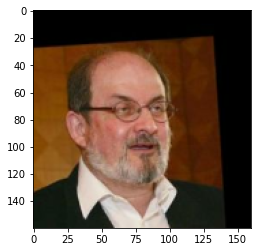

In [60]:
plt.imshow(images1[0])

In [61]:
# check the shape of the image to ensure it conforms to that of facenet
images1[0].shape

TensorShape([160, 160, 3])

### Loading the facenet model ###

In [62]:

base_model = models.load_model('../input/facenet-model/facenet_keras.h5')
base_model.load_weights("../input/facenet-model/facenet_keras_weights.h5")
base_model.trainable=False

In [63]:
# Siamese DistanceLayer class

class DistanceLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, compare):
        sum_squared = K.sum(K.square(anchor - compare), axis=1, keepdims=True)
        return K.sqrt(K.maximum(sum_squared, K.epsilon()))

In [64]:
features=Model(base_model.input, base_model.output)

anchor_input =Input((160,160,3))
compare_input =Input((160,160,3))

distances = DistanceLayer()(
    features(anchor_input),
    features(compare_input),
)

In [65]:
x= Dense(96, activation="relu")(distances)
x= Dropout(0.3)(x)
x= Dense(64)(x)
outputs = Dense(1, activation="sigmoid")(x)
model = Model(inputs=[anchor_input,compare_input],outputs=outputs)


In [66]:
def contrastive_loss(y, preds, margin=1):
    
    y = tf.cast(y, preds.dtype) #cast the true class label data type to the predicted class label data type
    
    # calculate the contrastive loss between the true labels and the predicted labels
    pred_sqr = K.square(preds)
    margin_sqr = K.square(K.maximum(margin - preds, 0))
    loss = 1-K.mean(y * pred_sqr + (1 - y) * margin_sqr) 
    return loss

### Running the model ###

In [67]:
model.compile(loss=contrastive_loss, optimizer=tensorflow.keras.optimizers.Adam(learning_rate = 0.001), 
              metrics=['accuracy'])

# Reduce learning rate when metric has stopped improving.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.2,
                                                patience = 5, min_lr = 0.001)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
model_2 (Functional)            (None, 128)          22808144    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
distance_layer_1 (DistanceLayer (None, 1)            0           model_2[0][0]              

In [68]:
history = model.fit([np.array(a)[:], np.array(b)[:]],np.array(y)[:],
                    validation_split = 0.2, 
                    epochs = 20, batch_size = 32,
                    callbacks = [reduce_lr])

Epoch 1/20
25/25 [==============================] - 68s 2s/step - loss: 0.5795 - accuracy: 0.4812 - val_loss: 0.4788 - val_accuracy: 0.5250
Epoch 2/20
25/25 [==============================] - 52s 2s/step - loss: 0.5229 - accuracy: 0.4787 - val_loss: 0.4764 - val_accuracy: 0.5250
Epoch 3/20
25/25 [==============================] - 52s 2s/step - loss: 0.5220 - accuracy: 0.4787 - val_loss: 0.4760 - val_accuracy: 0.5250
Epoch 4/20
25/25 [==============================] - 51s 2s/step - loss: 0.5218 - accuracy: 0.4787 - val_loss: 0.4758 - val_accuracy: 0.5250
Epoch 5/20
25/25 [==============================] - 52s 2s/step - loss: 0.5217 - accuracy: 0.4787 - val_loss: 0.4757 - val_accuracy: 0.5250
Epoch 6/20
25/25 [==============================] - 51s 2s/step - loss: 0.5217 - accuracy: 0.4787 - val_loss: 0.4756 - val_accuracy: 0.5250
Epoch 7/20
25/25 [==============================] - 52s 2s/step - loss: 0.5216 - accuracy: 0.4787 - val_loss: 0.4755 - val_accuracy: 0.5250
Epoch 8/20
25/25 [==

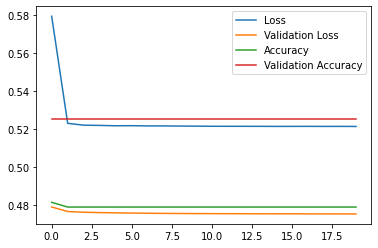

In [69]:
# Training Plot
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Loss", "Validation Loss", "Accuracy", "Validation Accuracy"])